# PaddleSeg实战--工业质检案例

工业质检即对工业产品表面的缺陷进行大小、位置、形状的检测。

以下是电池隔膜产品质检的示意图：

<img src='https://ai-studio-static-online.cdn.bcebos.com/0990f77d216847238e79e033f688d5067e7e23e2f89848e2a8c89e1868c7a0e8' width='60%' height='60%'>
     
### 任务挑战
- 常见的瑕疵呈现点状或线状，目标小，且区分度低。
- 一般产品的良品率非常高，可以获得的次品样本非常有限。
- 类别不均匀，瑕疵在全图中的占比低。
- 实时性要求高。

### 解决方案
针对以上的难点，我们使用4种解决方法：

- 使用分割网络进行工业质检，得到更精细化的识别效果，并且可以计算出瑕疵面积。
- 使用数据增强手段，扩充次品的样本量，提升分割效果。
- 使用针对类别不均衡问题效果的损失函数，我们应用dice loss，提高二分类分割精度。
- PaddleSeg提供众多的模型和网络backbone，使用MobileNet实现更快的预测速度。


**本次将以电子元件的划痕检测为例，首先使用DeeplabV3+模型进行分割。**

**随后我们会从数据增强、损失函数和网络backbone这3个方面一步步提高质检模型的性能。**

## 一、使用DeeplabV3+模型进行分割
首先，我们使用backbone为xception65的DeeplabV3+模型进行电子原件的划痕检测。

从数据集准备、预训练模型下载、参数配置、训练、评估、预测等流程进行全面地展示。
### step1 安装PaddleSeg

In [22]:
%cd ~/ 
# 下载PaddleSeg代码
#!git clone https://github.com/PaddlePaddle/PaddleSeg.git

# 解压打包好的PaddleSeg代码
!unzip -o -q data/data16973/PaddleSeg.zip
%cd ~/PaddleSeg


/home/aistudio
/home/aistudio/PaddleSeg


### step2 准备数据集
### 自定义数据集标注
对于自定义的数据集，PddleSeg已支持2种标注工具：LabelMe、精灵数据标注工具。[标注教程](https://github.com/PaddlePaddle/PaddleSeg/blob/release/v0.2.0/docs/data_prepare.md)
### 本教程所用数据集
为方便快速测试，我们已经准备了一份小型的电子原件数据集，包含2种类别：瑕疵、背景，
共有63张图片，其中训练集和验证集的数目为50和13.

![](https://ai-studio-static-online.cdn.bcebos.com/9766fa724f584d22a25face6924bfe48e320b88ad2d44da8a1fd92af76260f3c)
### 灰度标注图 VS 伪彩色标注图
一般的分割库使用单通道灰度图作为标注图片，根据它们的标注协议，像素值从0,1,2,3...开始，因此显示是全黑的图片。

灰度标注图的弊端：
1. 对图像标注后，无法直接观察标注是否正确。
2. 模型测试过程无法直接判断分割的实际效果。

PaddleSeg支持伪彩色图作为标注图片，仍然是单通道图片，**在不增加图片大小的基础上，却可以显示出彩色的效果，改善用户的使用体验。** 同时PaddleSeg仍然兼容灰度图标注，用户旧版的数据集可以不做修改，直接使用。如果用户想要转换成伪彩色标注图，我们也提供相应的转换工具。


In [ ]:
# 准备数据集
!unzip -o -q /home/aistudio/data/data16250/scratch_seg.zip -d dataset/

### step3 下载预训练模型
本课程使用在COCO数据集上预训练的DeeplabV3+模型，backbone为xception65。
预训练模型将存放在`PaddleSeg/pretrained_model/`目录下

![](https://ai-studio-static-online.cdn.bcebos.com/f116de1c88794bee81605ae03f62fdd115147ac31f874a198c53c82d0fcf2240)

In [ ]:
# 下载预训练模型
!python pretrained_model/download_model.py deeplabv3p_xception65_bn_coco

Pretrained Model download success!


### step4 参数配置

在训练前需要通过yaml文件进行相应参数的配置，我们提供了本实验的yaml文件，其位于`~/work/scratch_seg.yaml`。

In [ ]:
# 浏览配置文件
!cat ~/work/scratch_seg.yaml

EVAL_CROP_SIZE: (512, 512) # (width, height), for unpadding rangescaling and stepscaling
TRAIN_CROP_SIZE: (512, 512) # (width, height), for unpadding rangescaling and stepscaling
AUG: 
    AUG_METHOD: u"unpadding" # choice unpadding rangescaling and stepscaling
    FIX_RESIZE_SIZE: (512, 512) # (width, height), for unpadding
    MIRROR: False
BATCH_SIZE: 4 
DATASET: 
    DATA_DIR: "./dataset/scratch_seg/"
    NUM_CLASSES: 2
    TEST_FILE_LIST: "dataset/scratch_seg/val.txt"
    TRAIN_FILE_LIST: "dataset/scratch_seg/train.txt"
    VAL_FILE_LIST: "dataset/scratch_seg/val.txt"
MODEL: 
    MODEL_NAME: "deeplabv3p"
    DEEPLAB:
        BACKBONE: "xception_65" 
TRAIN:
    PRETRAINED_MODEL_DIR: "./pretrained_model/deeplabv3p_xception65_bn_coco/"
    MODEL_SAVE_DIR: "./saved_model/deeplabv3p_xception65_bn_scratch_seg/"
    SNAPSHOT_EPOCH: 10
TEST:
    TEST_MODEL: "./saved_model/deeplabv3p_xception65_bn_scratch_seg/final"
SOLVER:
    LR: 0.01
    NUM_EPOCHS: 20


### step5 进行配置和数据校验

为确保后续训练和测试的顺利进行，需要对数据集和yaml配置进行校验。

PaddleSeg提供相应的校验工具，帮助用户排查基本的数据和配置问题。

具体如下，支持通过YAML_FILE_PATH来指定配置文件。
```
# YAML_FILE_PATH为yaml配置文件路径
python pdseg/check.py --cfg ${YAML_FILE_PATH}
```
运行后，命令行将显示校验结果的概览信息，详细的错误信息可到detail.log文件中查看。

【注】

当校验结果出现`NOT PASS`选项的时候，说明相应的校验项存在问题，需进行更改，更改后再次进行校验直到所有校验项都为`PASS`。

结果中除校验项外还有`Doing ... statistics`的统计项，统计数据集信息，供参考。

In [ ]:
# 进行配置和数据校验，确保模型可以正常训练和测试
!python pdseg/check.py --cfg ~/work/scratch_seg.yaml 

{'AUG': {'AUG_METHOD': 'unpadding',
         'FIX_RESIZE_SIZE': (512, 512),
         'FLIP': False,
         'FLIP_RATIO': 0.5,
         'INF_RESIZE_VALUE': 500,
         'MAX_RESIZE_VALUE': 600,
         'MAX_SCALE_FACTOR': 2.0,
         'MIN_RESIZE_VALUE': 400,
         'MIN_SCALE_FACTOR': 0.5,
         'MIRROR': False,
         'RICH_CROP': {'ASPECT_RATIO': 0.33,
                       'BLUR': False,
                       'BLUR_RATIO': 0.1,
                       'BRIGHTNESS_JITTER_RATIO': 0.5,
                       'CONTRAST_JITTER_RATIO': 0.5,
                       'ENABLE': False,
                       'MAX_ROTATION': 15,
                       'MIN_AREA_RATIO': 0.5,
                       'SATURATION_JITTER_RATIO': 0.5},
         'SCALE_STEP_SIZE': 0.25},
 'BATCH_SIZE': 4,
 'DATALOADER': {'BUF_SIZE': 256, 'NUM_WORKERS': 8},
 'DATASET': {'DATA_DIM': 3,
             'DATA_DIR': './dataset/scratch_seg/',
             'IGNORE_INDEX': 255,
             'IMAGE_TYPE': 'rgb',
      

### step6 训练
当检验通过后，可进行训练，训练的使用方式如下：

```
!python pdseg/train.py ${FLAGS} ${OPTIONS}
```

训练脚本支持通过不同的FLAGS来开启特定功能，也支持通过OPTIONS来修改默认的训练配置。

运行以下命令进行划痕检测训练，其中通过`--cfg`参数传入配置文件, `--use_gpu`启动GPU进行训练，`BATCH_SIZE`修改为4.

**note:**
PaddleSeg中共有三处可设置模型参数：

- 命令窗口传递的参数。
- configs目录下的yaml文件。
- 默认参数，位于pdseg/utils/config.py。

对于相同的参数，传递的优先级为：命令窗口 > yaml文件 > config.py。即同一个参数，优先级较高的将覆盖掉优先级较低的。

In [6]:
# 模型训练
!python pdseg/train.py --cfg ~/work/scratch_seg.yaml --use_gpu BATCH_SIZE 4

{'AUG': {'AUG_METHOD': 'unpadding',
         'FIX_RESIZE_SIZE': (512, 512),
         'FLIP': False,
         'FLIP_RATIO': 0.5,
         'INF_RESIZE_VALUE': 500,
         'MAX_RESIZE_VALUE': 600,
         'MAX_SCALE_FACTOR': 2.0,
         'MIN_RESIZE_VALUE': 400,
         'MIN_SCALE_FACTOR': 0.5,
         'MIRROR': False,
         'RICH_CROP': {'ASPECT_RATIO': 0.33,
                       'BLUR': False,
                       'BLUR_RATIO': 0.1,
                       'BRIGHTNESS_JITTER_RATIO': 0.5,
                       'CONTRAST_JITTER_RATIO': 0.5,
                       'ENABLE': False,
                       'MAX_ROTATION': 15,
                       'MIN_AREA_RATIO': 0.5,
                       'SATURATION_JITTER_RATIO': 0.5},
         'SCALE_STEP_SIZE': 0.25},
 'BATCH_SIZE': 4,
 'DATALOADER': {'BUF_SIZE': 256, 'NUM_WORKERS': 8},
 'DATASET': {'DATA_DIM': 3,
             'DATA_DIR': './dataset/scratch_seg/',
             'IGNORE_INDEX': 255,
             'IMAGE_TYPE': 'rgb',
      

### step7 评估
根据训练好的模型，在验证集上进行评估，计算得出准确率（acc）、mean IoU、Kappa系数等指标。

![](https://ai-studio-static-online.cdn.bcebos.com/da38279d0ecb44dfabc0c152ccc2f05ad286a97f2aad48e685c7d7199a228fa9)

Kappa系数：一个用于一致性检验的指标，可以用于衡量分类的效果。kappa系数的计算是基于混淆矩阵的，取值为-1到1之间，通常大于0。

$$ Kappa = \frac{p_0-p_e}{1-p_e}$$

其中$p_0$为分类器的准确率，$p_e$为随机分类器的准确率。

![](https://ai-studio-static-online.cdn.bcebos.com/deef000ad80949b19197162c71740cde8be1261cde814953b6f81037eb6136c7)



In [7]:
# 模型评估
!python pdseg/eval.py --cfg ~/work/scratch_seg.yaml --use_gpu

{'AUG': {'AUG_METHOD': 'unpadding',
         'FIX_RESIZE_SIZE': (512, 512),
         'FLIP': False,
         'FLIP_RATIO': 0.5,
         'INF_RESIZE_VALUE': 500,
         'MAX_RESIZE_VALUE': 600,
         'MAX_SCALE_FACTOR': 2.0,
         'MIN_RESIZE_VALUE': 400,
         'MIN_SCALE_FACTOR': 0.5,
         'MIRROR': False,
         'RICH_CROP': {'ASPECT_RATIO': 0.33,
                       'BLUR': False,
                       'BLUR_RATIO': 0.1,
                       'BRIGHTNESS_JITTER_RATIO': 0.5,
                       'CONTRAST_JITTER_RATIO': 0.5,
                       'ENABLE': False,
                       'MAX_ROTATION': 15,
                       'MIN_AREA_RATIO': 0.5,
                       'SATURATION_JITTER_RATIO': 0.5},
         'SCALE_STEP_SIZE': 0.25},
 'BATCH_SIZE': 4,
 'DATALOADER': {'BUF_SIZE': 256, 'NUM_WORKERS': 8},
 'DATASET': {'DATA_DIM': 3,
             'DATA_DIR': './dataset/scratch_seg/',
             'IGNORE_INDEX': 255,
             'IMAGE_TYPE': 'rgb',
      

### step8 预测

根据训练好的模型，对测试集进行预测，并将预测结果保存在`visual/visual_results`目录下。



In [8]:
# 模型预测
!python pdseg/vis.py --cfg ~/work/scratch_seg.yaml --use_gpu

{'AUG': {'AUG_METHOD': 'unpadding',
         'FIX_RESIZE_SIZE': (512, 512),
         'FLIP': False,
         'FLIP_RATIO': 0.5,
         'INF_RESIZE_VALUE': 500,
         'MAX_RESIZE_VALUE': 600,
         'MAX_SCALE_FACTOR': 2.0,
         'MIN_RESIZE_VALUE': 400,
         'MIN_SCALE_FACTOR': 0.5,
         'MIRROR': False,
         'RICH_CROP': {'ASPECT_RATIO': 0.33,
                       'BLUR': False,
                       'BLUR_RATIO': 0.1,
                       'BRIGHTNESS_JITTER_RATIO': 0.5,
                       'CONTRAST_JITTER_RATIO': 0.5,
                       'ENABLE': False,
                       'MAX_ROTATION': 15,
                       'MIN_AREA_RATIO': 0.5,
                       'SATURATION_JITTER_RATIO': 0.5},
         'SCALE_STEP_SIZE': 0.25},
 'BATCH_SIZE': 4,
 'DATALOADER': {'BUF_SIZE': 256, 'NUM_WORKERS': 8},
 'DATASET': {'DATA_DIM': 3,
             'DATA_DIR': './dataset/scratch_seg/',
             'IGNORE_INDEX': 255,
             'IMAGE_TYPE': 'rgb',
      

#### 预测结果展示

原图、标注图、预测结果并排显示。


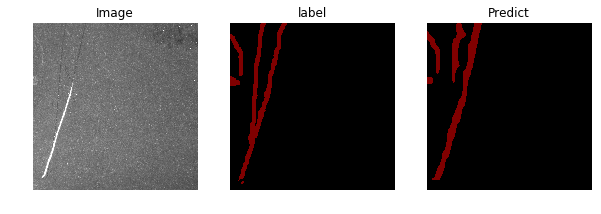

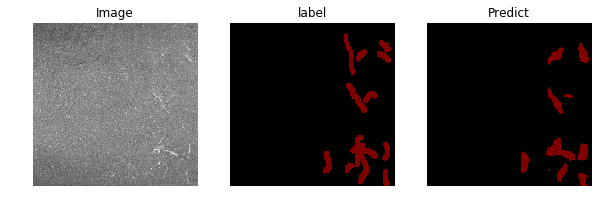

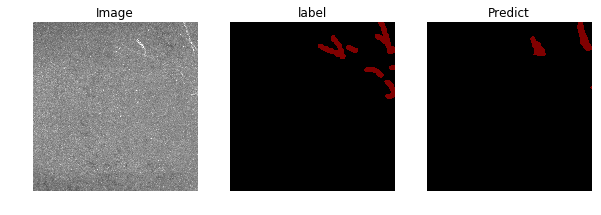

In [21]:
import matplotlib.pyplot as plt
import os
# 定义显示函数
def display(img_name):
    image_dir = os.path.join("dataset/scratch_seg/JPEGImages", img_name)
    label_dir = os.path.join("dataset/scratch_seg/SegmentationClass/pre_encoded",img_name)
    mask_dir = os.path.join("visual/visual", img_name)
    img_dir = [image_dir, label_dir, mask_dir]
    
    plt.figure(figsize=(10, 10))

    title = ['Image', 'label', 'Predict']
    
    for i in range(len(title)):
        plt.subplot(1, len(title), i+1)
        plt.title(title[i])
        img = plt.imread(img_dir[i])
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# 预测结果展示
# 注：这里仅显示其中3张图片的效果。
# 注：第一次运行可能无法显示，再运行一次即可。
img_name = "6-10-15ms.png"
display(img_name)
img_name = "1-14-15ms.png"
display(img_name)
img_name = "2-1-15ms.png"
display(img_name)


## 二、数据增强
###  数据增强基本流程：
![](https://ai-studio-static-online.cdn.bcebos.com/5c05890b13514d5b88a71c6ef427eb8c12c75d2746654ad3839bd53d0c7b9ba6)

![](https://ai-studio-static-online.cdn.bcebos.com/c28df89fc6624fe2a321fcce3f5892fad92da74307104c8db168b8233bfe7169)

PaddleSeg支持十余种数据增强策略，由于时间有限，这里我们重点介绍以下在训练阶段中用到两类数据增强方式：Rich crop和图像翻转。

所有数据增强的代码见pdseg/data_aug.py, 说明文档见[链接](https://github.com/PaddlePaddle/PaddleSeg/blob/release/v0.3.0/docs/data_aug.md)



### Rich Crop  

Rich Crop是PaddleSeg结合实际业务经验开放的一套数据增强策略，面向标注数据少，测试数据情况繁杂的分割业务场景使用的数据增强策略。流程如下图所示:

![RichCrop示意图](https://ai-studio-static-online.cdn.bcebos.com/636d3bf788124c14ae7a358b6e76bb50f844692fe796452d982aa3876663da13)

rich crop是指对图像进行多种变换，保证在训练过程中数据的丰富多样性，PaddleSeg支持以下几种变换。`AUG.RICH_CROP.ENABLE`为False时会直接跳过该步骤。

- blur
图像加模糊，使用开关`AUG.RICH_CROP.BLUR`，为False时该项功能关闭。`AUG.RICH_CROP.BLUR_RATIO`控制加入模糊的概率。

- rotation
图像旋转，`AUG.RICH_CROP.MAX_ROTATION`控制最大旋转角度。

- scale_aspect
图像尺度和长宽比调整，从图像中crop一定区域出来之后在某一尺度和长宽比内进行resize。参数`AUG.RICH_CROP.MIN_AREA_RATIO`代表裁剪图像占原始图像的最小面积比，参数`AUG.RICH_CROP.ASPECT_RATIO`控制裁剪图像的宽高比范围，图像宽高比在[`AUG.RICH_CROP.ASPECT_RATIO`, 1/`AUG.RICH_CROP.ASPECT_RATIO`]范围内随机取值。

- color jitter
图像颜色调整，控制参数`AUG.RICH_CROP.BRIGHTNESS_JITTER_RATIO`、`AUG.RICH_CROP.SATURATION_JITTER_RATIO`、`AUG.RICH_CROP.CONTRAST_JITTER_RATIO`。



In [10]:
%cd ~/PaddleSeg
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sys
sys.path.append('/home/aistudio/PaddleSeg/pdseg')
from utils.config import cfg
from models.model_builder import ModelPhase
from data_aug import resize

# 定义显示函数
def show(img, title, c=1):
    plt.figure(figsize=(15, 15))
    xticks = np.arange(0, 1280*c, 100)
    yticks = np.arange(0, 960*c, 100)
    
    im_num = len(img) if isinstance(img, list) else 1
    for i in range(im_num):
        plt.subplot(1, im_num, i+1)
        plt.title(title[i])
        plt.imshow(cv2.cvtColor(img[i],cv2.COLOR_BGR2RGB))
        # plt.axis('off')
        plt.xticks(xticks)
        plt.yticks(yticks)
    plt.show()

/home/aistudio/PaddleSeg


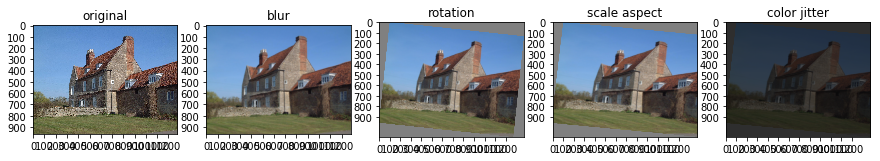

In [11]:
import pdseg.data_aug as aug

# rand crop参数
cfg.AUG.RICH_CROP.ENABLE = True
cfg.AUG.RICH_CROP.BLUR = True
cfg.AUG.RICH_CROP.BLUR_RATIO = 1
cfg.AUG.RICH_CROP.MAX_ROTATION = 45
cfg.AUG.RICH_CROP.MIN_AREA_RATIO = 0.3
cfg.AUG.RICH_CROP.ASPECT_RATIO = 0.2
cfg.AUG.RICH_CROP.BRIGHTNESS_JITTER_RATIO = 0.8
cfg.AUG.RICH_CROP.CONTRAST_JITTER_RATIO = 0.2
cfg.AUG.RICH_CROP.SATURATION_JITTER_RATIO = 0.5

# 展示rich crop图片效果
show_list = []
img = cv2.imread('/home/aistudio/work/test.jpg')
grt = np.zeros(img.shape[:2], np.uint8)
show_list.append(img)
if cfg.AUG.RICH_CROP.ENABLE:
    # 图像模糊
    if cfg.AUG.RICH_CROP.BLUR:
        n = int(1.0 / cfg.AUG.RICH_CROP.BLUR_RATIO)
        if np.random.randint(0, n) == 0:
            img = cv2.GaussianBlur(img, (21, 21), 0, 0)
        show_list.append(img) 
    # 随机旋转
    img, grt = aug.random_rotation(img, grt,
        rich_crop_max_rotation=cfg.AUG.RICH_CROP.MAX_ROTATION,
        mean_value=cfg.DATASET.PADDING_VALUE)
    show_list.append(img)
    # 随机尺度长宽比变化
    img, grt = aug.rand_scale_aspect(img, grt,
        rich_crop_min_scale=cfg.AUG.RICH_CROP.MIN_AREA_RATIO,
        rich_crop_aspect_ratio=cfg.AUG.RICH_CROP.ASPECT_RATIO)
    show_list.append(img) 
    # 颜色空间扰动
    img = aug.hsv_color_jitter(img,
        brightness_jitter_ratio=cfg.AUG.RICH_CROP.BRIGHTNESS_JITTER_RATIO,
        saturation_jitter_ratio=cfg.AUG.RICH_CROP.SATURATION_JITTER_RATIO,
        contrast_jitter_ratio=cfg.AUG.RICH_CROP.CONTRAST_JITTER_RATIO)
    show_list.append(img) 
  
show(show_list, ['original', 'blur', 'rotation', 'scale aspect', 'color jitter'])

#### 图像翻转
PaddleSeg支持以下2种翻转方式：

- 左右翻转（Mirror）

- 上下翻转（Flip）

以上2种开关独立运作，可组合使用。故图像翻转一共有如下4种可能的情况：

<img src='https://ai-studio-static-online.cdn.bcebos.com/acb81c2af39949768c383f88b5b872e6310a11438da0424faa062c6301e7e586' width='70%' height='70%'>

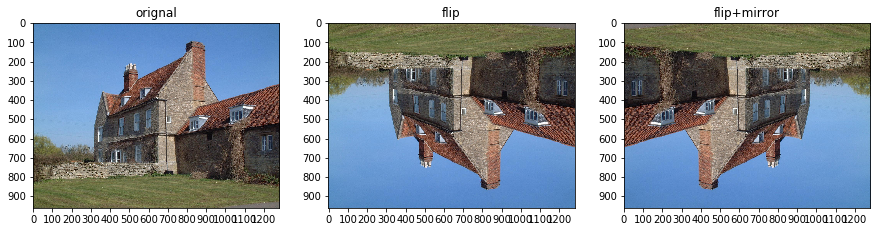

In [12]:
# 图像镜像左右翻转
cfg.AUG.MIRROR = True
# 图像上下翻转开关，True/False
cfg.AUG.FLIP = True
# 图像启动上下翻转的概率，0-1
cfg.AUG.FLIP_RATIO = 0.5

# 展示上下、左右翻转图片效果
img = cv2.imread('/home/aistudio/work/test.jpg')
show_list = [img]
if cfg.AUG.FLIP:
    n = int(1.0 / cfg.AUG.FLIP_RATIO)
    if np.random.randint(0, n) == 0:
        img = img[::-1, :, :]
show_list.append(img)
if cfg.AUG.MIRROR:
    if np.random.randint(0, 2) == 1:
        img = img[:, ::-1, :]
show_list.append(img)  
show(show_list, ['orignal', 'flip', 'flip+mirror'])

## 三、损失函数

目前PaddleSeg提供了三种loss函数，分别为softmax loss(sotfmax with cross entroy loss)、dice loss(dice coefficient loss)和bce loss(binary cross entroy loss)， 其中dice loss和bce loss适用与二分类情况。

**softmax loss的定义：**

$$f(p_k)=\frac{e^{p_k}}{\sum_j e^{p_j}}$$
$$softmax\ \ loss = -\sum_{c=0}^C y_c \log(f(p_c))$$

其中 y 表示ground truth，p 表示网络输出。


**dice loss的定义：**

$$ dice\ \ loss = 1-\frac{2|Y\bigcap{P}|}{|Y|+|P|}$$

其中 Y 表示ground truth，P 表示预测结果。

其中$|Y\bigcap{P}|$ 表示Y和P的共有元素数， 实际计算通过求两者的乘积之和进行计算。如下所示：
<div style="text-align: center">
<img src=https://ai-studio-static-online.cdn.bcebos.com/ab80c8a9e1064dc99a41c6dee75ce43a68d7b2db347c408788865efb4bf60cf7>
</div>

### 正负样本不均衡问题
在图像分割中，softmax loss同等的对待每一像素，因此当背景占据绝大部分的情况下， 网络将偏向于背景的学习，使网络对目标的提取能力变差。dice loss通过计算预测与标注之间的重叠部分计算损失函数，loss随着重叠面积的增大而减小，避免了类别不均衡带来的影响，能够取得更好的效果。

在实际应用中dice loss往往与bce loss结合使用，提高模型训练的稳定性。


接下来，通过数据增强和dice loss来提升我们的分割精度。

其中数据增强以较为简单通用的图像翻转策略：`MIRROR`和`FLIP`为例进行实验。

In [13]:
# 训练
!python pdseg/train.py --cfg ~/work/scratch_seg.yaml --use_gpu \
SOLVER.LOSS "['dice_loss','bce_loss']" \
AUG.MIRROR True \
AUG.FLIP True 


{'AUG': {'AUG_METHOD': 'unpadding',
         'FIX_RESIZE_SIZE': (512, 512),
         'FLIP': True,
         'FLIP_RATIO': 0.5,
         'INF_RESIZE_VALUE': 500,
         'MAX_RESIZE_VALUE': 600,
         'MAX_SCALE_FACTOR': 2.0,
         'MIN_RESIZE_VALUE': 400,
         'MIN_SCALE_FACTOR': 0.5,
         'MIRROR': True,
         'RICH_CROP': {'ASPECT_RATIO': 0.33,
                       'BLUR': False,
                       'BLUR_RATIO': 0.1,
                       'BRIGHTNESS_JITTER_RATIO': 0.5,
                       'CONTRAST_JITTER_RATIO': 0.5,
                       'ENABLE': False,
                       'MAX_ROTATION': 15,
                       'MIN_AREA_RATIO': 0.5,
                       'SATURATION_JITTER_RATIO': 0.5},
         'SCALE_STEP_SIZE': 0.25},
 'BATCH_SIZE': 4,
 'DATALOADER': {'BUF_SIZE': 256, 'NUM_WORKERS': 8},
 'DATASET': {'DATA_DIM': 3,
             'DATA_DIR': './dataset/scratch_seg/',
             'IGNORE_INDEX': 255,
             'IMAGE_TYPE': 'rgb',
        

**使用数据增强、dice loss是否真的提升了分割精度？**

接下来进行测试：

In [14]:
# 评估
!python pdseg/eval.py --cfg ~/work/scratch_seg.yaml --use_gpu \
SOLVER.LOSS "['dice_loss','bce_loss']"

{'AUG': {'AUG_METHOD': 'unpadding',
         'FIX_RESIZE_SIZE': (512, 512),
         'FLIP': False,
         'FLIP_RATIO': 0.5,
         'INF_RESIZE_VALUE': 500,
         'MAX_RESIZE_VALUE': 600,
         'MAX_SCALE_FACTOR': 2.0,
         'MIN_RESIZE_VALUE': 400,
         'MIN_SCALE_FACTOR': 0.5,
         'MIRROR': False,
         'RICH_CROP': {'ASPECT_RATIO': 0.33,
                       'BLUR': False,
                       'BLUR_RATIO': 0.1,
                       'BRIGHTNESS_JITTER_RATIO': 0.5,
                       'CONTRAST_JITTER_RATIO': 0.5,
                       'ENABLE': False,
                       'MAX_ROTATION': 15,
                       'MIN_AREA_RATIO': 0.5,
                       'SATURATION_JITTER_RATIO': 0.5},
         'SCALE_STEP_SIZE': 0.25},
 'BATCH_SIZE': 4,
 'DATALOADER': {'BUF_SIZE': 256, 'NUM_WORKERS': 8},
 'DATASET': {'DATA_DIM': 3,
             'DATA_DIR': './dataset/scratch_seg/',
             'IGNORE_INDEX': 255,
             'IMAGE_TYPE': 'rgb',
      

{'AUG': {'AUG_METHOD': 'unpadding',
         'FIX_RESIZE_SIZE': (512, 512),
         'FLIP': False,
         'FLIP_RATIO': 0.5,
         'INF_RESIZE_VALUE': 500,
         'MAX_RESIZE_VALUE': 600,
         'MAX_SCALE_FACTOR': 2.0,
         'MIN_RESIZE_VALUE': 400,
         'MIN_SCALE_FACTOR': 0.5,
         'MIRROR': False,
         'RICH_CROP': {'ASPECT_RATIO': 0.33,
                       'BLUR': False,
                       'BLUR_RATIO': 0.1,
                       'BRIGHTNESS_JITTER_RATIO': 0.5,
                       'CONTRAST_JITTER_RATIO': 0.5,
                       'ENABLE': False,
                       'MAX_ROTATION': 15,
                       'MIN_AREA_RATIO': 0.5,
                       'SATURATION_JITTER_RATIO': 0.5},
         'SCALE_STEP_SIZE': 0.25},
 'BATCH_SIZE': 4,
 'DATALOADER': {'BUF_SIZE': 256, 'NUM_WORKERS': 8},
 'DATASET': {'DATA_DIM': 3,
             'DATA_DIR': './dataset/scratch_seg/',
             'IGNORE_INDEX': 255,
             'IMAGE_TYPE': 'rgb',
      

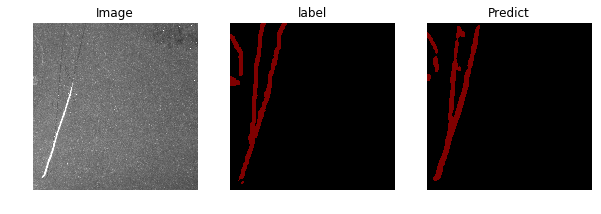

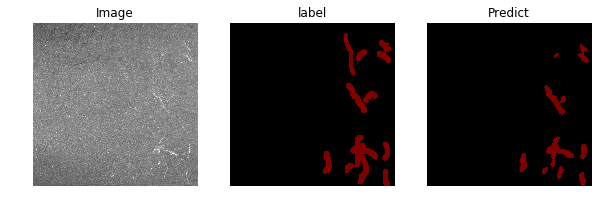

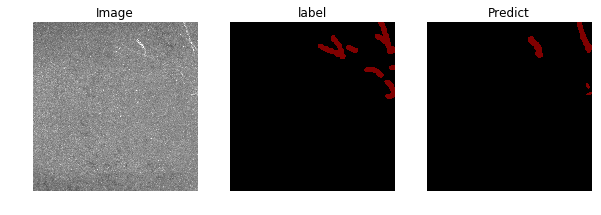

In [15]:
# 预测
!python pdseg/vis.py --cfg ~/work/scratch_seg.yaml --use_gpu \
SOLVER.LOSS "['dice_loss','bce_loss']"


# 预测结果展示
# 注：这里仅显示其中3张图片的效果。
img_name = "6-10-15ms.png"
display(img_name)
img_name = "1-14-15ms.png"
display(img_name)
img_name = "2-1-15ms.png"
display(img_name)

## 四、PaddleSeg进阶使用-- 骨干网络选型

**Encoder-Decoder结构：**

![](https://ai-studio-static-online.cdn.bcebos.com/43b8aee77b8c48e98054a8748f74f65a55aa50be7faf4dd59d642b0f398bc6f7)

**Xception vs MobileNet**

DeeplabV3+模型采取主流的encoder-decoder结构，在encoder过程中会使用骨干网络（backbone）进行特征的提取，不同的backbone提取特征的计算开销千差万别。

PaddleSeg针对DeepLabv3+模型提供了`Xception`和`mobilenetv2`两类骨干网络（backbone），可根据具体应用场景选择相应的模型。

Xception具有更高的分割精度，有3种选项：`xception_65（默认）`、`xception_41`、`xception_71`。一般xception71精度最高，xception41速度最快，xception65则平衡精度和速度。

MobileNet最初是为移动端设计的，它的计算速度相比Xception更快，计算所占显存更小，模型体积也更小。

如果对实时性要求高，建议使用MobileNet，运行示例如下：

In [16]:
# 下载MobileNet预训练模型
!python pretrained_model/download_model.py deeplabv3p_mobilenetv2-1-0_bn_coco

Pretrained Model download success!


In [17]:
# 训练
!python pdseg/train.py --cfg ~/work/scratch_seg.yaml --use_gpu \
MODEL.MODEL_NAME "deeplabv3p" \
MODEL.DEEPLAB.BACKBONE "mobilenetv2" \
MODEL.DEEPLAB.DEPTH_MULTIPLIER 1.0 \
MODEL.DEEPLAB.ENCODER_WITH_ASPP False \
MODEL.DEEPLAB.ENABLE_DECODER False \
TRAIN.PRETRAINED_MODEL_DIR "./pretrained_model/deeplabv3p_mobilenetv2-1-0_bn_coco/" \
TRAIN.MODEL_SAVE_DIR "./saved_model/deeplabv3p_mobilenet_bn_scratch_seg/" \
SOLVER.LOSS "['dice_loss','bce_loss']" \
AUG.MIRROR True \
AUG.FLIP True 

{'AUG': {'AUG_METHOD': 'unpadding',
         'FIX_RESIZE_SIZE': (512, 512),
         'FLIP': True,
         'FLIP_RATIO': 0.5,
         'INF_RESIZE_VALUE': 500,
         'MAX_RESIZE_VALUE': 600,
         'MAX_SCALE_FACTOR': 2.0,
         'MIN_RESIZE_VALUE': 400,
         'MIN_SCALE_FACTOR': 0.5,
         'MIRROR': True,
         'RICH_CROP': {'ASPECT_RATIO': 0.33,
                       'BLUR': False,
                       'BLUR_RATIO': 0.1,
                       'BRIGHTNESS_JITTER_RATIO': 0.5,
                       'CONTRAST_JITTER_RATIO': 0.5,
                       'ENABLE': False,
                       'MAX_ROTATION': 15,
                       'MIN_AREA_RATIO': 0.5,
                       'SATURATION_JITTER_RATIO': 0.5},
         'SCALE_STEP_SIZE': 0.25},
 'BATCH_SIZE': 4,
 'DATALOADER': {'BUF_SIZE': 256, 'NUM_WORKERS': 8},
 'DATASET': {'DATA_DIM': 3,
             'DATA_DIR': './dataset/scratch_seg/',
             'IGNORE_INDEX': 255,
             'IMAGE_TYPE': 'rgb',
        

**实际预测中，MobileNet相比Xception预测速度是否有提升呢？**

接下来进行测试：

In [18]:
# 评估
!python pdseg/eval.py --cfg ~/work/scratch_seg.yaml --use_gpu \
MODEL.MODEL_NAME "deeplabv3p" \
MODEL.DEEPLAB.BACKBONE "mobilenetv2" \
MODEL.DEEPLAB.DEPTH_MULTIPLIER 1.0 \
MODEL.DEEPLAB.ENCODER_WITH_ASPP False \
MODEL.DEEPLAB.ENABLE_DECODER False \
SOLVER.LOSS "['dice_loss','bce_loss']" \
TEST.TEST_MODEL "./saved_model/deeplabv3p_mobilenet_bn_scratch_seg/final"

{'AUG': {'AUG_METHOD': 'unpadding',
         'FIX_RESIZE_SIZE': (512, 512),
         'FLIP': False,
         'FLIP_RATIO': 0.5,
         'INF_RESIZE_VALUE': 500,
         'MAX_RESIZE_VALUE': 600,
         'MAX_SCALE_FACTOR': 2.0,
         'MIN_RESIZE_VALUE': 400,
         'MIN_SCALE_FACTOR': 0.5,
         'MIRROR': False,
         'RICH_CROP': {'ASPECT_RATIO': 0.33,
                       'BLUR': False,
                       'BLUR_RATIO': 0.1,
                       'BRIGHTNESS_JITTER_RATIO': 0.5,
                       'CONTRAST_JITTER_RATIO': 0.5,
                       'ENABLE': False,
                       'MAX_ROTATION': 15,
                       'MIN_AREA_RATIO': 0.5,
                       'SATURATION_JITTER_RATIO': 0.5},
         'SCALE_STEP_SIZE': 0.25},
 'BATCH_SIZE': 4,
 'DATALOADER': {'BUF_SIZE': 256, 'NUM_WORKERS': 8},
 'DATASET': {'DATA_DIM': 3,
             'DATA_DIR': './dataset/scratch_seg/',
             'IGNORE_INDEX': 255,
             'IMAGE_TYPE': 'rgb',
      

测试结果分析：

MobileNet预测速度step/sec大约为10（每秒10个batch）。而Xeception预测速度step/sec大约为5。

**MobileNet相比Xception预测速度大约可以提升至2倍。**

{'AUG': {'AUG_METHOD': 'unpadding',
         'FIX_RESIZE_SIZE': (512, 512),
         'FLIP': False,
         'FLIP_RATIO': 0.5,
         'INF_RESIZE_VALUE': 500,
         'MAX_RESIZE_VALUE': 600,
         'MAX_SCALE_FACTOR': 2.0,
         'MIN_RESIZE_VALUE': 400,
         'MIN_SCALE_FACTOR': 0.5,
         'MIRROR': False,
         'RICH_CROP': {'ASPECT_RATIO': 0.33,
                       'BLUR': False,
                       'BLUR_RATIO': 0.1,
                       'BRIGHTNESS_JITTER_RATIO': 0.5,
                       'CONTRAST_JITTER_RATIO': 0.5,
                       'ENABLE': False,
                       'MAX_ROTATION': 15,
                       'MIN_AREA_RATIO': 0.5,
                       'SATURATION_JITTER_RATIO': 0.5},
         'SCALE_STEP_SIZE': 0.25},
 'BATCH_SIZE': 4,
 'DATALOADER': {'BUF_SIZE': 256, 'NUM_WORKERS': 8},
 'DATASET': {'DATA_DIM': 3,
             'DATA_DIR': './dataset/scratch_seg/',
             'IGNORE_INDEX': 255,
             'IMAGE_TYPE': 'rgb',
      

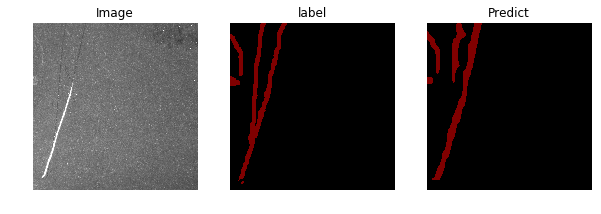

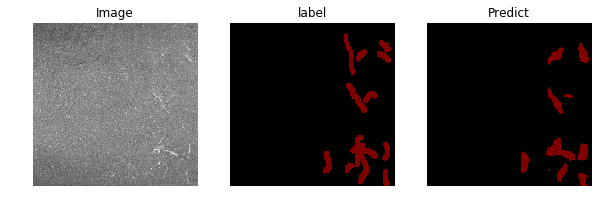

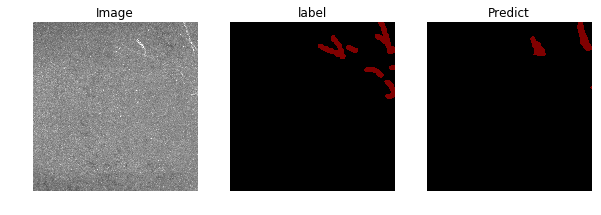

In [19]:
# 预测
!python pdseg/vis.py --cfg ~/work/scratch_seg.yaml --use_gpu \
MODEL.MODEL_NAME "deeplabv3p" \
MODEL.DEEPLAB.BACKBONE "mobilenetv2" \
MODEL.DEEPLAB.DEPTH_MULTIPLIER 1.0 \
MODEL.DEEPLAB.ENCODER_WITH_ASPP False \
MODEL.DEEPLAB.ENABLE_DECODER False  \
SOLVER.LOSS "['dice_loss','bce_loss']"  \
TEST.TEST_MODEL "./saved_model/deeplabv3p_mobilenet_bn_scratch_seg/final"

# 预测结果展示
# 注：这里仅显示其中3张图片的效果。
img_name = "6-10-15ms.png"
display(img_name)
img_name = "1-14-15ms.png"
display(img_name)
img_name = "2-1-15ms.png"
display(img_name)

预测结果显示，使用moblinet在提升速度的同时，依然拥有不错的精度。